In [100]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from astropy.visualization.mpl_normalize import ImageNormalize, LogStretch
import matplotlib.pyplot as plt

## make aperture box

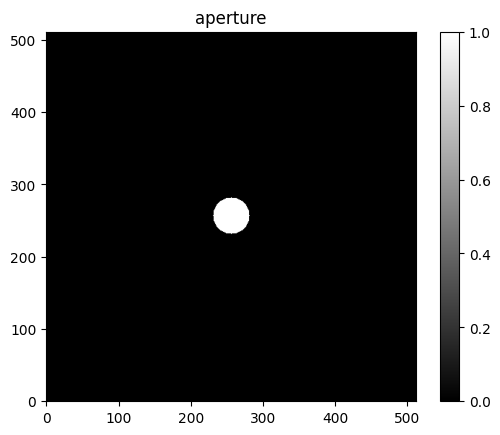

In [101]:
num_frames = 1000
aperture_size = 512
radius = 50/2 

aperture = np.zeros((aperture_size, aperture_size))
center = (aperture_size / 2, aperture_size / 2)
for i in range(aperture.shape[0]):
    for j in range(aperture.shape[1]):
        if (i - center[0])**2 + (j - center[1])**2 <= radius**2:
            aperture[i, j] = 1

plt.imshow(aperture, origin="lower", cmap = "gray")  
plt.title("aperture")
plt.colorbar()
plt.show()


# Phase space

In [102]:

def get_phase_array():
    phase_size = (num_frames + 512)*2
    radius = 50/2 
    phase_box = np.zeros((phase_size, phase_size))
    mean = 0
    std = 1
    random_box = np.random.normal(loc=mean, scale=std,size=phase_box.shape)
    #plt.imshow(random_box, origin = "lower")
    #plt.title(f"random box, num_frame = {num_frames}")
    #plt.colorbar()
    #plt.show()
    # k array with distances to the center
    center_x, center_y = phase_size // 2, phase_size // 2
    y, x = np.ogrid[:phase_size, :phase_size]
    distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    k = (distance_from_center + 0.00001)
    #plt.figure(figsize=(12, 5))
    #plt.subplot(1, 2, 1)
    #plt.imshow(k, origin="lower")
    #plt.title(f"Distance from center (k array)")
    #plt.colorbar()
    kolmogorov_spectrum = k ** (-11/3)
    #plt.subplot(1, 2, 2)
    #plt.imshow(kolmogorov_spectrum, origin="lower")
    #plt.title("kolmogorov_spectrum (k**(-11/3))")
    #plt.colorbar()
    #plt.show()
    # Calculate the multiplied array and perform IFFT
    Multiplied_array = random_box * ((kolmogorov_spectrum)**(1/2))
    ifft_shifted = np.fft.ifftshift(Multiplied_array)
    ifft = np.fft.ifft2(ifft_shifted)
    phase_array = ifft
    #plt.figure()
    #plt.imshow(np.abs(phase_array), origin='lower', cmap='viridis') 
    #plt.colorbar()
    #plt.show()
    return phase_array


In [103]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

def compute_fft(image):
    fft_image = np.fft.fft2(image)
    fft_image_shifted = np.fft.fftshift(fft_image)
    return fft_image_shifted

def amplitude_resolution(r0_ratio):
    value = 1.02 * (1/r0_ratio) ** (5 / 3)
    return value

def normalize_phase_space(phase_array, r0_ratio, num_frames):
    data_cube = np.zeros((num_frames, 512, 512))
    sum_of_cube_array = np.zeros((512, 512))
    for i in range(num_frames):
        ith_box = phase_array[i:512 + i, i:512 + i]
        ith_box_var = np.var(ith_box)
        wanted_var = amplitude_resolution(r0_ratio)
        correction_value_for_ith_box = np.sqrt(wanted_var / ith_box_var) 
        corrected_ith_box = ith_box * correction_value_for_ith_box
        multiply_by_aperture = aperture * np.exp(1j * corrected_ith_box * 5.78)
        PSF = (np.abs(compute_fft(multiply_by_aperture)))**2
        data_cube[i] = np.abs(PSF)
        sum_of_cube_array += np.abs(PSF)
    sum = np.sum(data_cube, axis = 0)

    return data_cube, sum



## PSF for cropped box:

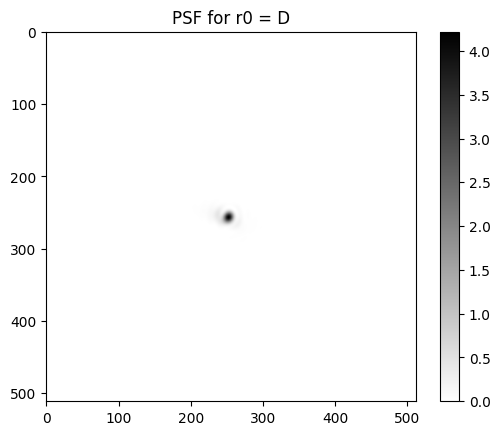

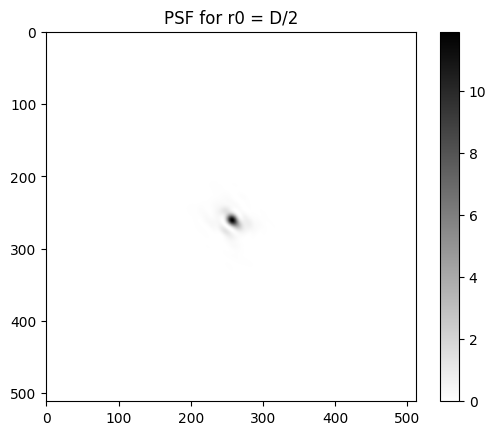

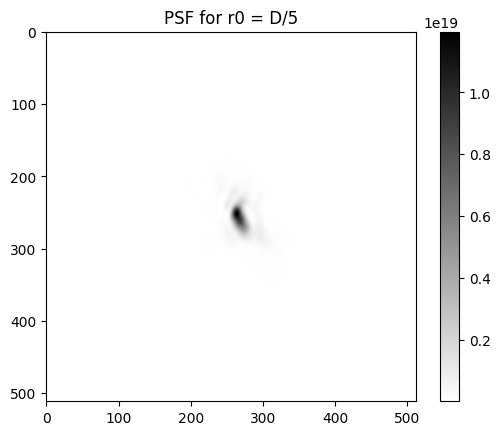

In [104]:
phase_array_1= get_phase_array()
data_cube_1, sum_of_cube_array_1 = normalize_phase_space(phase_array_1, 1 , 1000)
plt.imshow(data_cube_1[0], cmap = "gray_r")
plt.title("PSF for r0 = D")
plt.colorbar()
plt.show()

phase_array_2= get_phase_array()
data_cube_half, sum_of_cube_array_half = normalize_phase_space(phase_array_2, 1/2 , 1000)
plt.imshow(data_cube_half[0], cmap = "gray_r")
plt.title("PSF for r0 = D/2")
plt.colorbar()
plt.show()

phase_array_3 = get_phase_array()
data_cube_fifth, sum_of_cube_array_fifth = normalize_phase_space(phase_array_3, 1/5 , 1000)
plt.imshow(data_cube_fifth[0], cmap = "gray_r")
plt.title("PSF for r0 = D/5")
plt.colorbar()
plt.show()


## Sum of frames

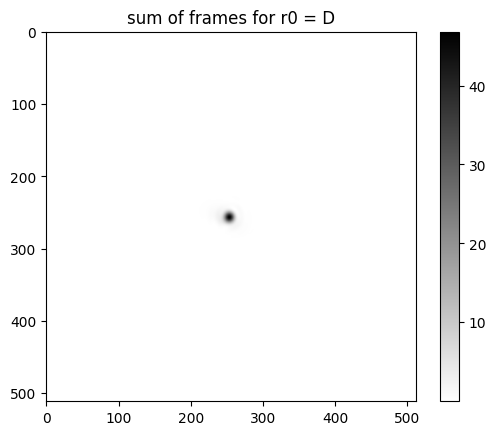

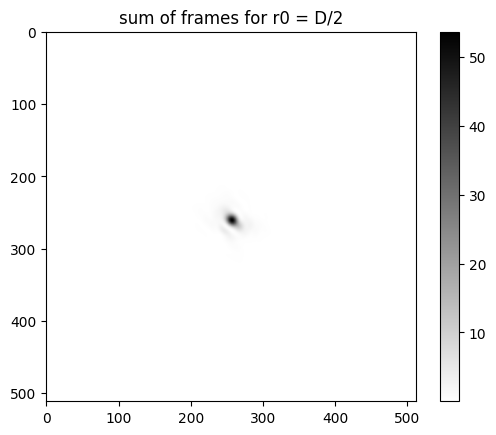

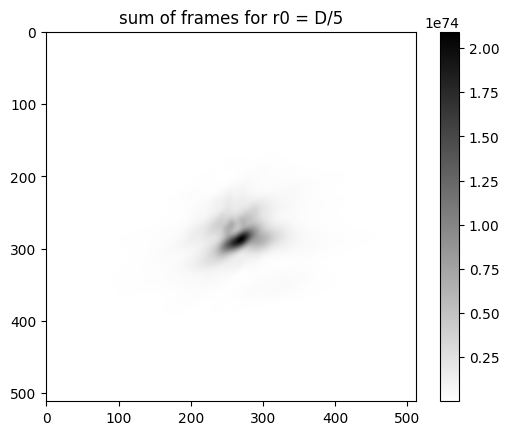

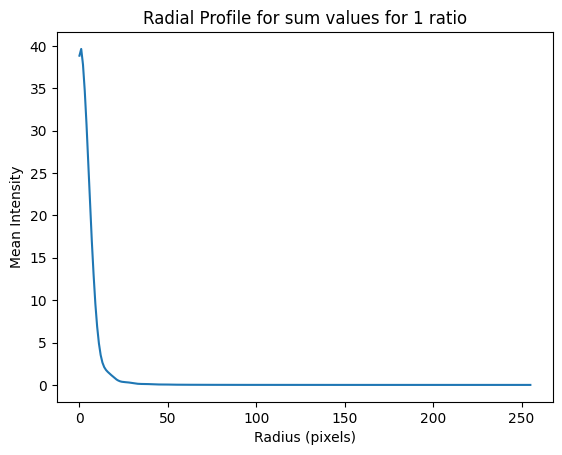

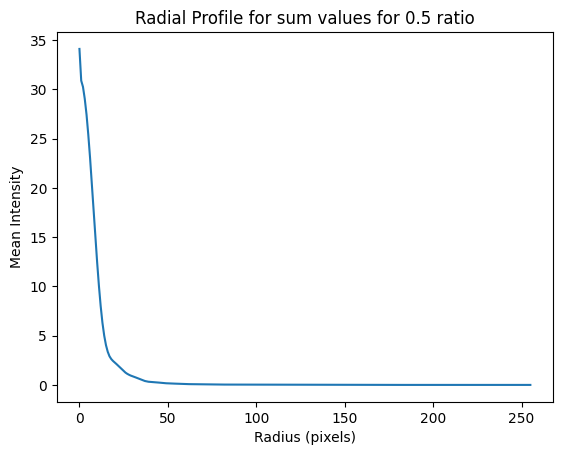

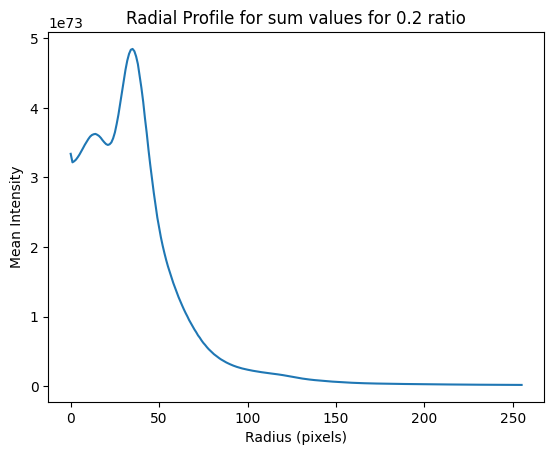

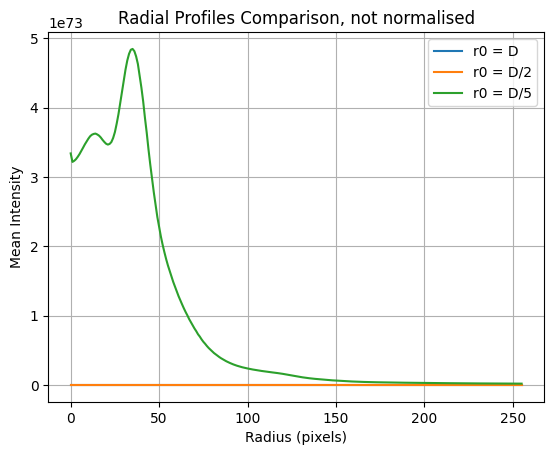

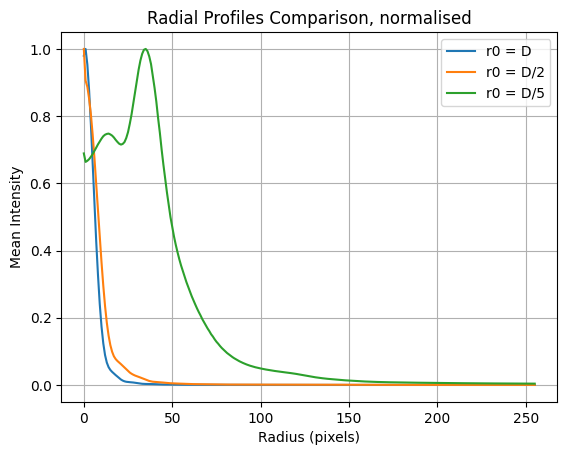

In [105]:
def get_line_profile(image, start_point, angle, length):
    x0, y0 = start_point
    angle_rad = np.deg2rad(angle)
    profile = []

    for r in range(length):
        x = int(x0 + r * np.cos(angle_rad))
        y = int(y0 + r * np.sin(angle_rad))

        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            profile.append(np.abs(image[y, x])) 
        else:
            profile.append(np.nan)

    return profile

def radial_profile(image, ratio):
    length = int(np.min(image.shape) / 2)
    center = np.array(image.shape) // 2
    profiles = []
    
    for theta in np.linspace(0, 2 * np.pi, num=360, endpoint=False):
        profile = get_line_profile(image, center, np.rad2deg(theta), length)
        profiles.append(profile)
    x_ax = np.arange(0, length)
    mean_profile = np.mean(profiles, axis=0)
    plt.plot(x_ax, mean_profile)
    plt.xlabel('Radius (pixels)')
    plt.ylabel('Mean Intensity')
    plt.title(f'Radial Profile for sum values for {ratio} ratio')
    plt.show()
    return x_ax, mean_profile
    

plt.imshow(sum_of_cube_array_1, cmap = "gray_r")
plt.title("sum of frames for r0 = D")
plt.colorbar()
plt.show()

plt.imshow(sum_of_cube_array_half, cmap = "gray_r")
plt.title("sum of frames for r0 = D/2")
plt.colorbar()
plt.show()

plt.imshow(sum_of_cube_array_fifth, cmap = "gray_r")
plt.title("sum of frames for r0 = D/5")
plt.colorbar()
plt.show()

x_ax_1, mean_profile_1 = radial_profile(sum_of_cube_array_1, 1)
x_ax_half, mean_profile_half = radial_profile(sum_of_cube_array_half, 1/2)
x_ax_fifth, mean_profile_fifth = radial_profile(sum_of_cube_array_fifth, 1/5)


plt.figure()
plt.plot(x_ax_1, mean_profile_1, label='r0 = D')
plt.plot(x_ax_1, mean_profile_half, label='r0 = D/2')
plt.plot(x_ax_1, mean_profile_fifth, label='r0 = D/5')
plt.xlabel('Radius (pixels)')
plt.ylabel('Mean Intensity')
plt.title('Radial Profiles Comparison, not normalised')
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.plot(x_ax_1, (mean_profile_1 / np.max(mean_profile_1)), label='r0 = D')
plt.plot(x_ax_1, mean_profile_half / np.max(mean_profile_half), label='r0 = D/2')
plt.plot(x_ax_1, mean_profile_fifth / np.max(mean_profile_fifth), label='r0 = D/5')
plt.xlabel('Radius (pixels)')
plt.ylabel('Mean Intensity')
plt.title('Radial Profiles Comparison, normalised')
plt.legend()
plt.grid(True)
plt.show()


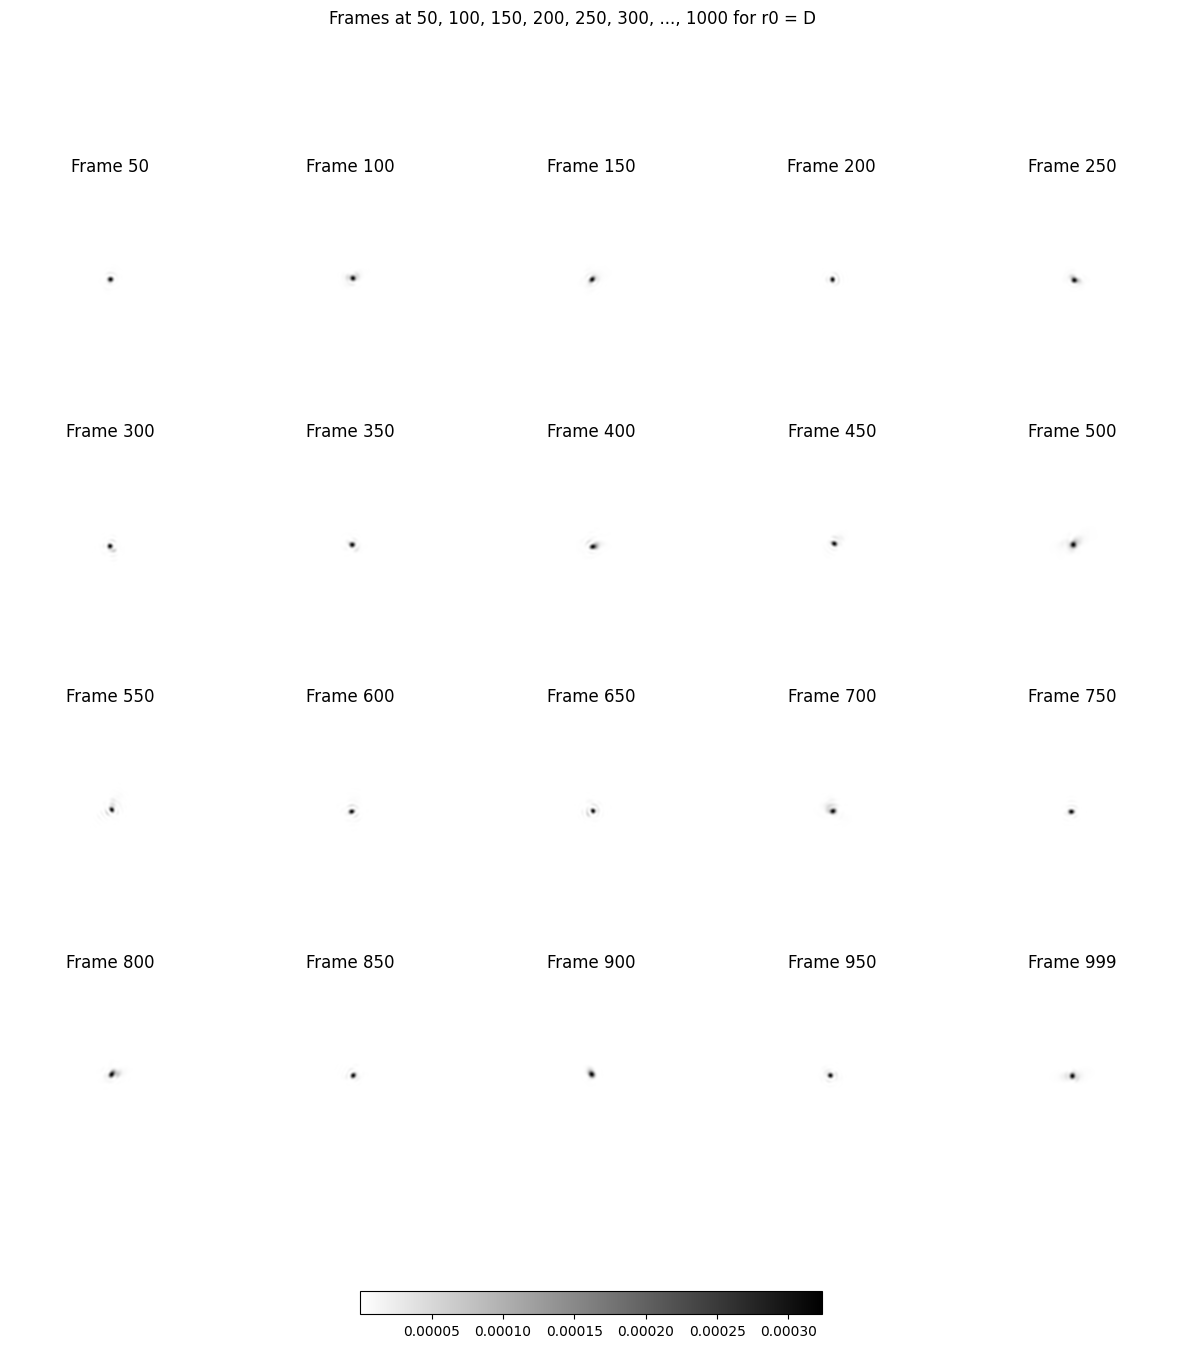

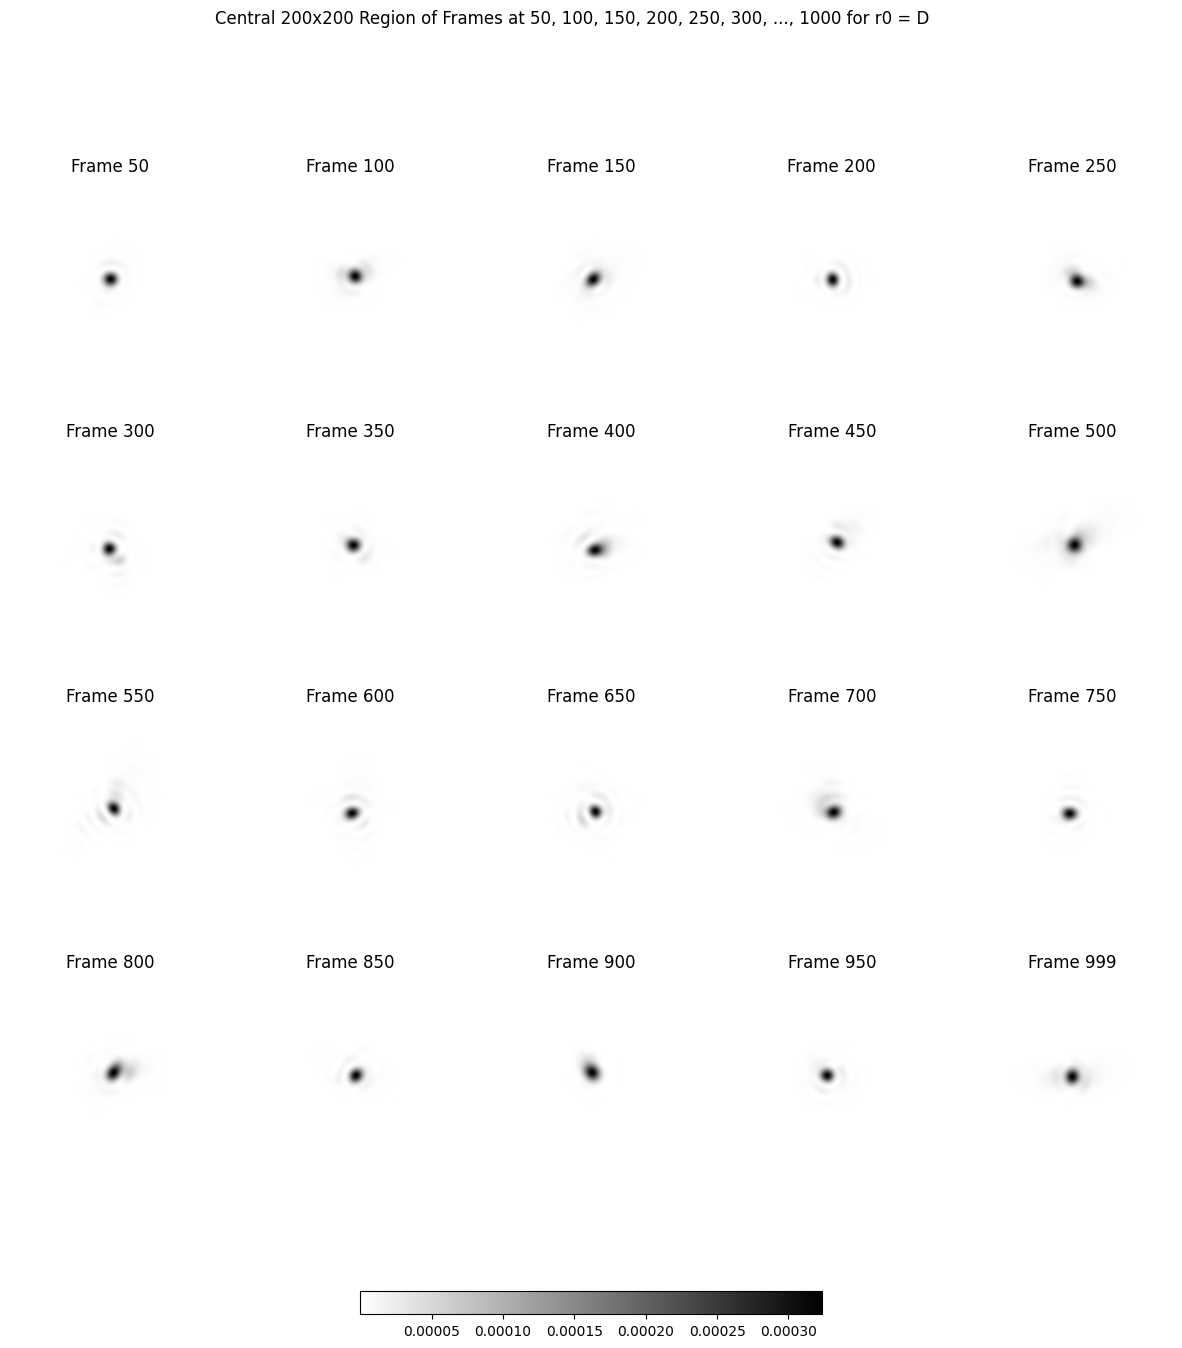

In [106]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(15, 15))
axes = axes.flatten()

frames = [50, 100, 150, 200,250, 300,350, 400,450, 500,550, 600,650, 700,750, 800,850, 900, 950, 999]

for ax, frame in zip(axes, frames):
    im = ax.imshow(data_cube_1[frame], origin='lower', cmap="gray_r")
    ax.set_title(f'Frame {frame}')
    ax.axis('off')

fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.suptitle("Frames at 50, 100, 150, 200, 250, 300, ..., 1000 for r0 = D")
plt.show()


center_x, center_y = data_cube_1.shape[1] // 2, data_cube_1.shape[2] // 2
box_size = 100  

fig, axes = plt.subplots(4, 5, figsize=(15, 15))
axes = axes.flatten()

frames = [50, 100, 150, 200,250, 300,350, 400,450, 500,550, 600,650, 700,750, 800,850, 900, 950, 999]

for ax, frame in zip(axes, frames):
    im = ax.imshow(data_cube_1[frame, center_x-box_size:center_x+box_size, center_y-box_size:center_y+box_size], 
                   origin='lower', cmap="gray_r")
    ax.set_title(f'Frame {frame}')
    ax.axis('off')

fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.suptitle("Central 200x200 Region of Frames at 50, 100, 150, 200, 250, 300, ..., 1000 for r0 = D")
plt.show()

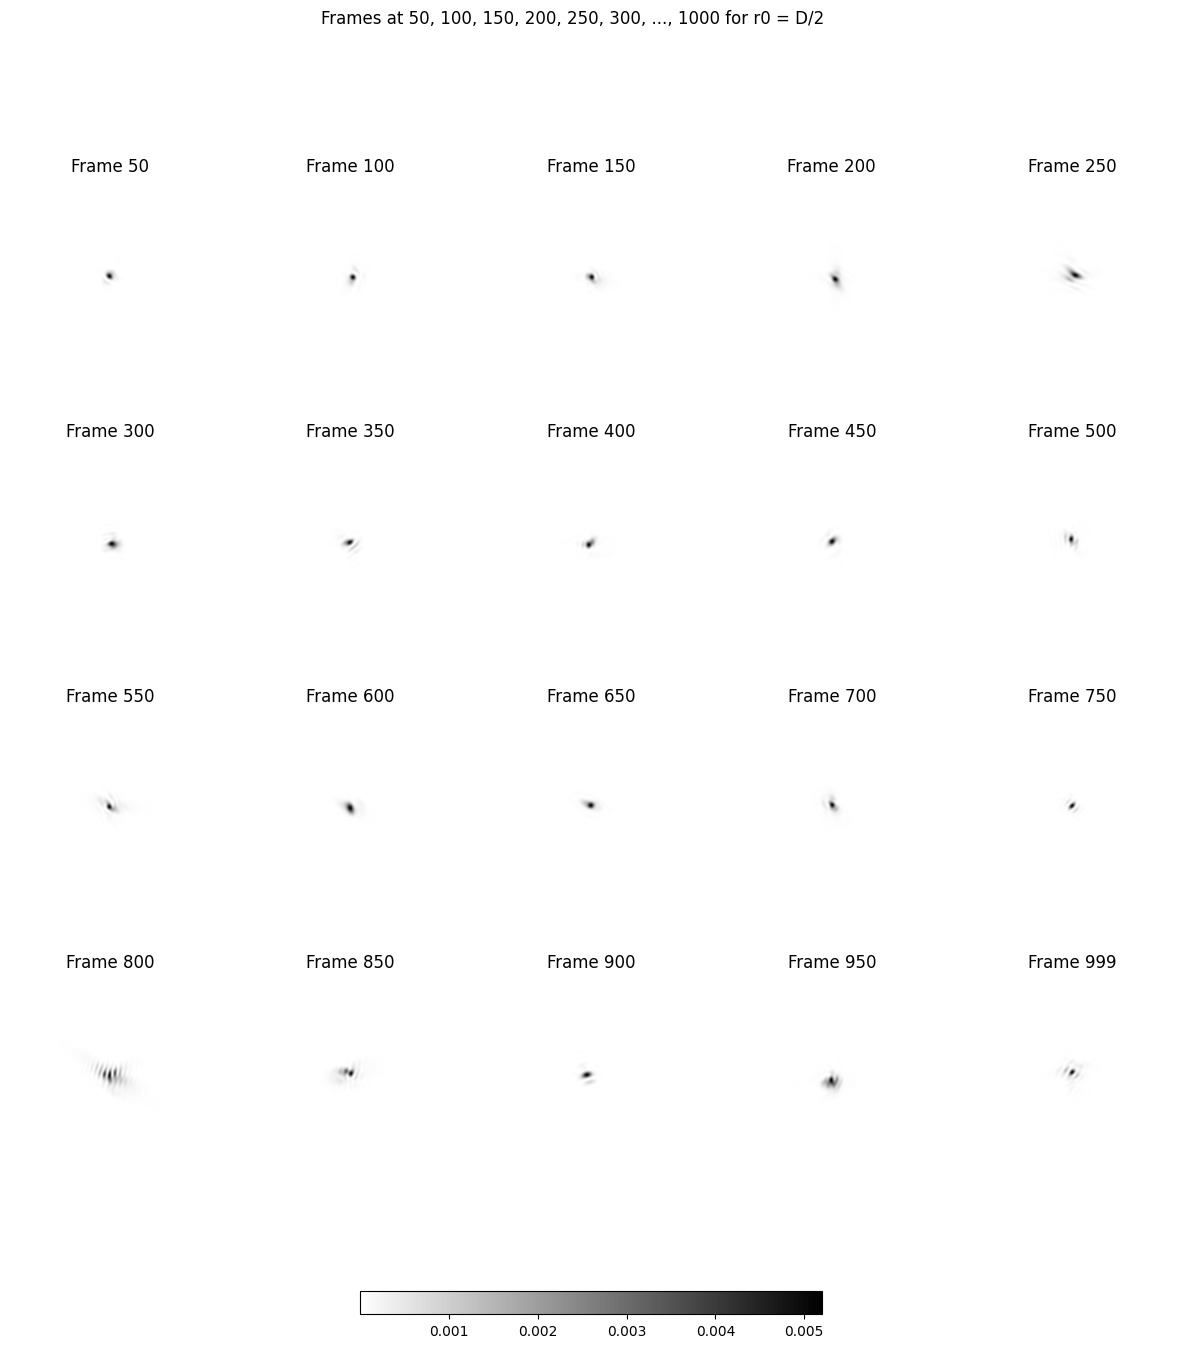

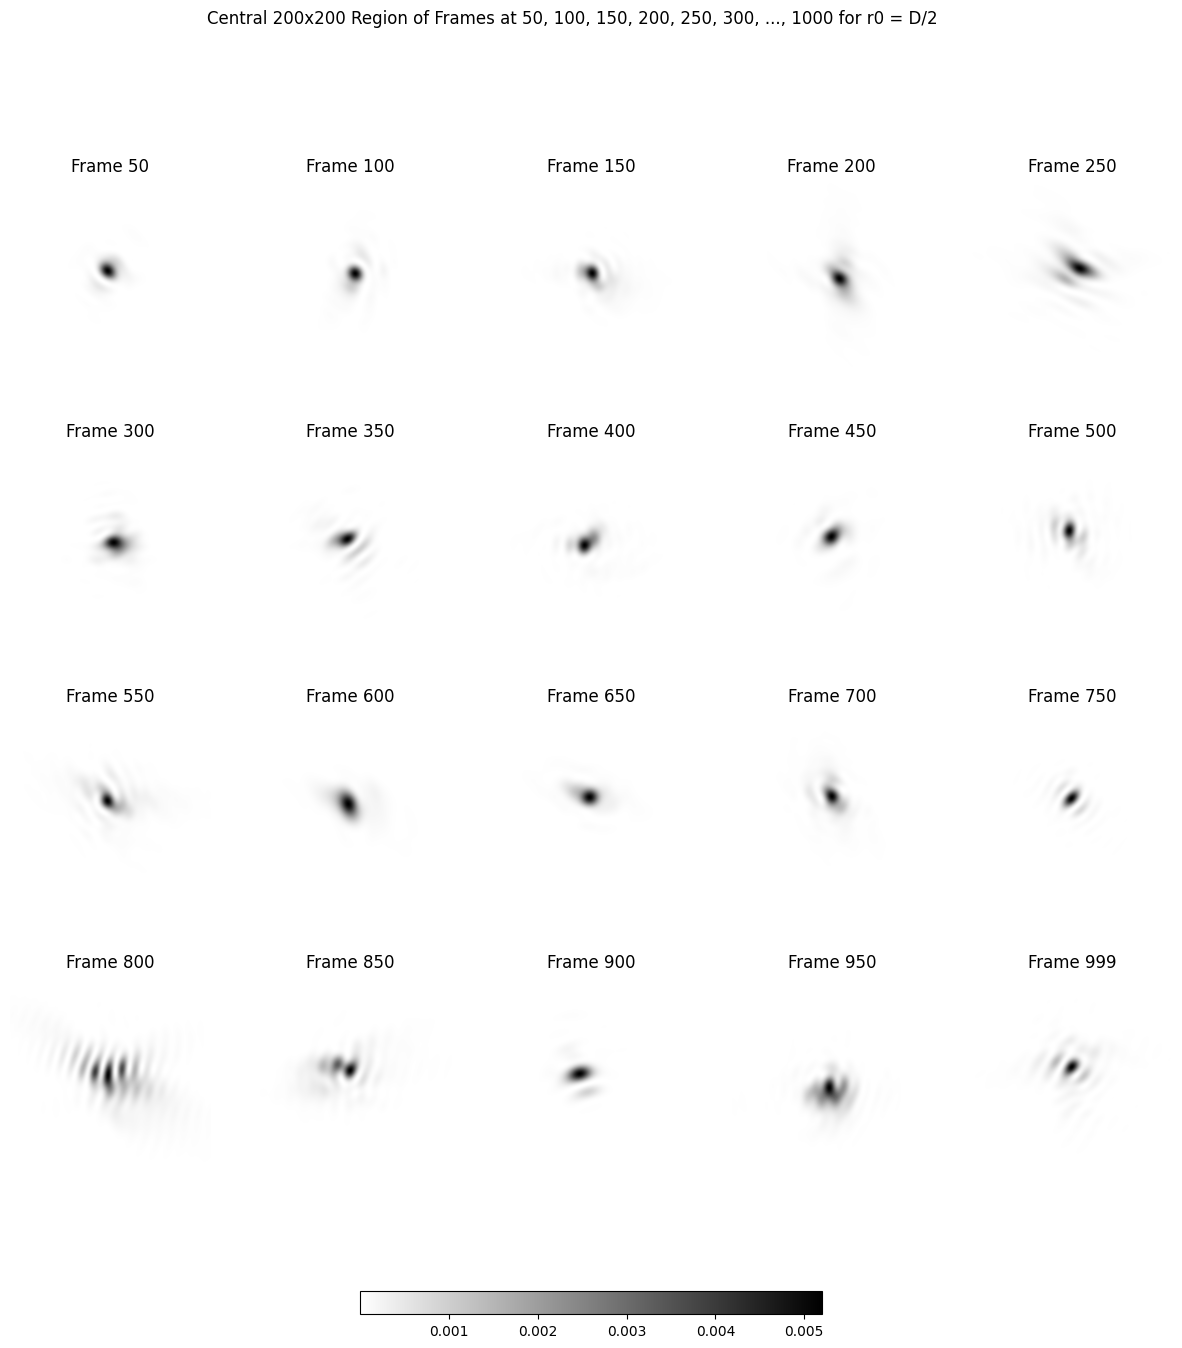

In [107]:

fig, axes = plt.subplots(4, 5, figsize=(15, 15))
axes = axes.flatten()

frames = [50, 100, 150, 200,250, 300,350, 400,450, 500,550, 600,650, 700,750, 800,850, 900, 950, 999]

for ax, frame in zip(axes, frames):
    im = ax.imshow(data_cube_half[frame], origin='lower', cmap="gray_r")
    ax.set_title(f'Frame {frame}')
    ax.axis('off')

fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.suptitle("Frames at 50, 100, 150, 200, 250, 300, ..., 1000 for r0 = D/2")
plt.show()

center_x, center_y = data_cube_1.shape[1] // 2, data_cube_1.shape[2] // 2
box_size = 100 

fig, axes = plt.subplots(4, 5, figsize=(15, 15))
axes = axes.flatten()

frames = [50, 100, 150, 200,250, 300,350, 400,450, 500,550, 600,650, 700,750, 800,850, 900, 950, 999]

for ax, frame in zip(axes, frames):
    im = ax.imshow(data_cube_half[frame, center_x-box_size:center_x+box_size, center_y-box_size:center_y+box_size], 
                   origin='lower', cmap="gray_r")
    ax.set_title(f'Frame {frame}')
    ax.axis('off')

fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.suptitle("Central 200x200 Region of Frames at 50, 100, 150, 200, 250, 300, ..., 1000 for r0 = D/2")
plt.show()

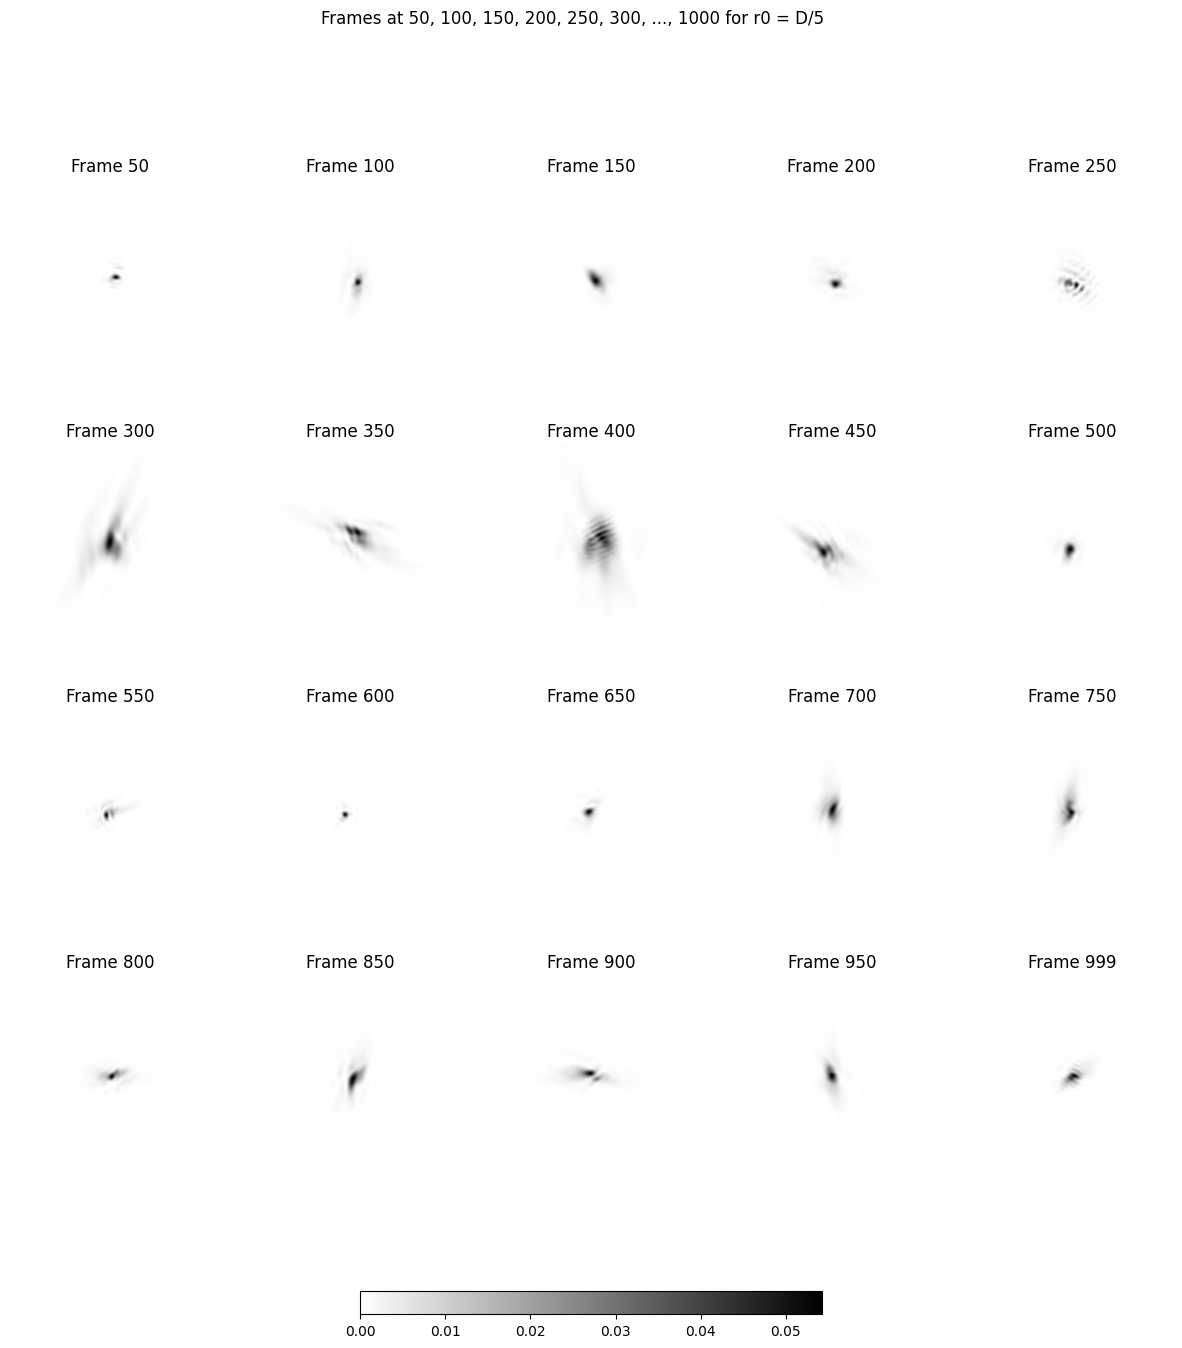

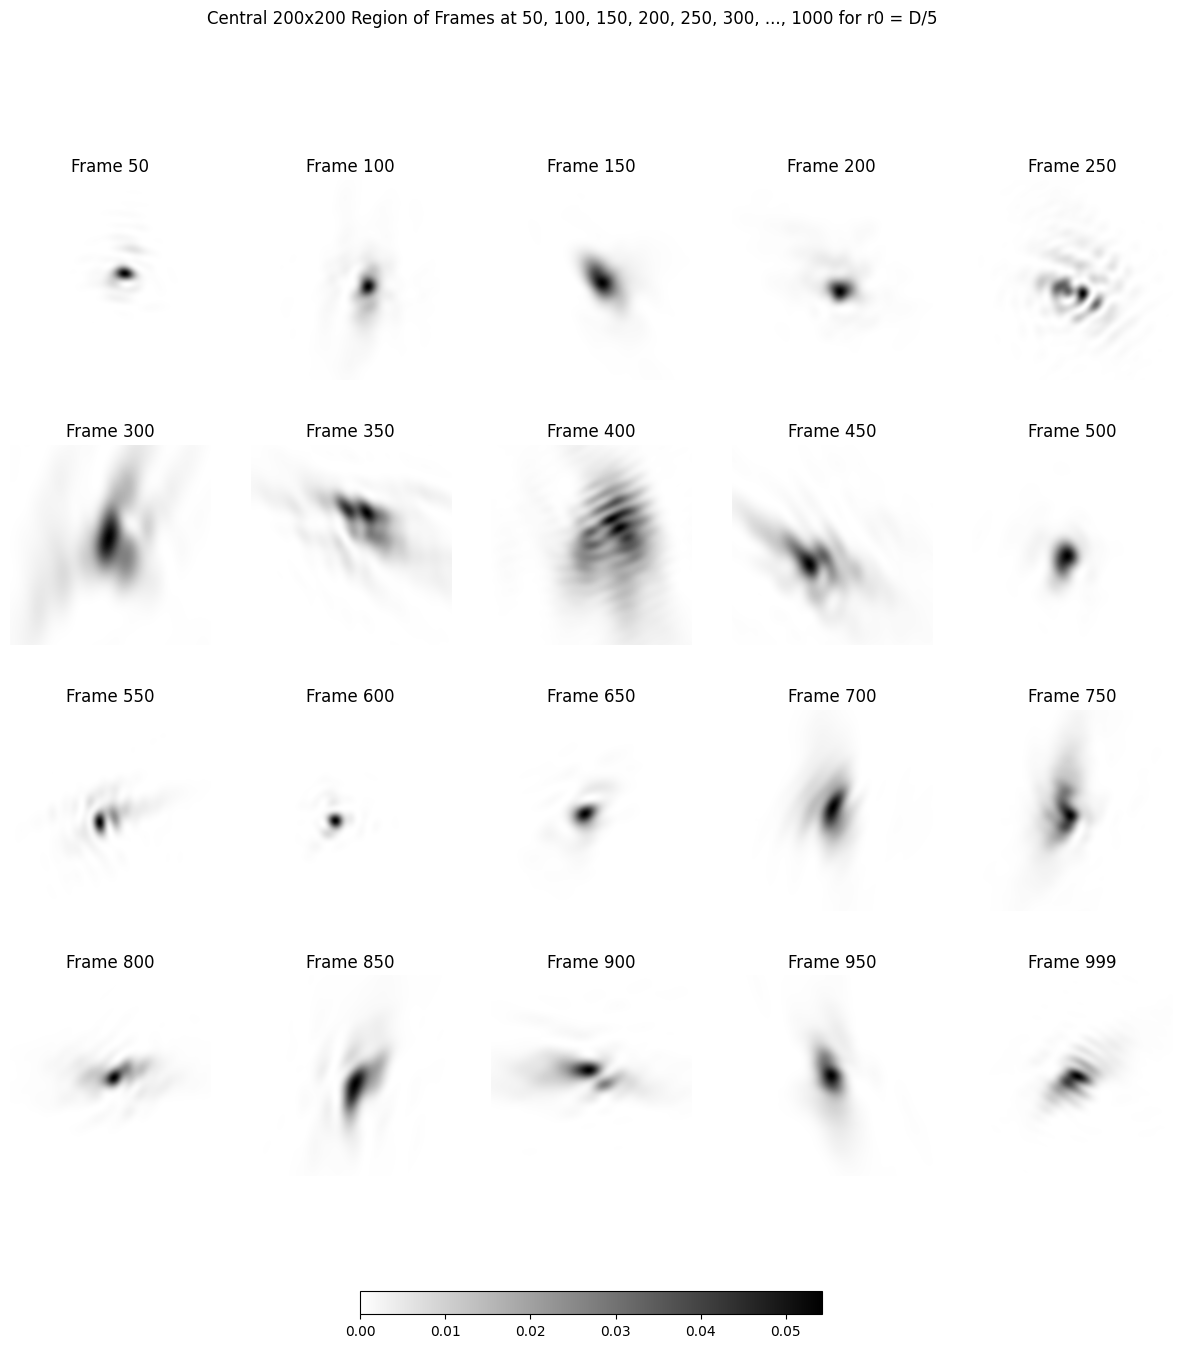

In [108]:
fig, axes = plt.subplots(4, 5, figsize=(15, 15))
axes = axes.flatten()

frames = [50, 100, 150, 200,250, 300,350, 400,450, 500,550, 600,650, 700,750, 800,850, 900, 950, 999]

for ax, frame in zip(axes, frames):
    im = ax.imshow(data_cube_fifth[frame], origin='lower', cmap="gray_r")
    ax.set_title(f'Frame {frame}')
    ax.axis('off')

fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.suptitle("Frames at 50, 100, 150, 200, 250, 300, ..., 1000 for r0 = D/5")
plt.show()

center_x, center_y = data_cube_1.shape[1] // 2, data_cube_1.shape[2] // 2
box_size = 100  

fig, axes = plt.subplots(4, 5, figsize=(15, 15))
axes = axes.flatten()

frames = [50, 100, 150, 200,250, 300,350, 400,450, 500,550, 600,650, 700,750, 800,850, 900, 950, 999]

for ax, frame in zip(axes, frames):
    im = ax.imshow(data_cube_fifth[frame, center_x-box_size:center_x+box_size, center_y-box_size:center_y+box_size], 
                   origin='lower', cmap="gray_r")
    ax.set_title(f'Frame {frame}')
    ax.axis('off')

fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
plt.suptitle("Central 200x200 Region of Frames at 50, 100, 150, 200, 250, 300, ..., 1000 for r0 = D/5")
plt.show()

# normalized images then make animation

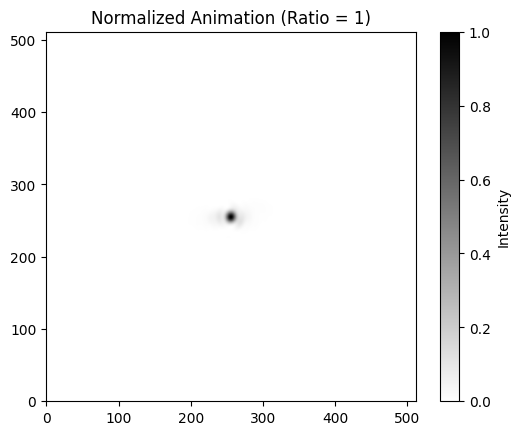

In [109]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

def normalize_frame(frame):
    norm_frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))
    return norm_frame

normalized_data_cube = np.array([normalize_frame(frame) for frame in data_cube_1])

fig, ax = plt.subplots()

im = ax.imshow(normalized_data_cube[0], origin='lower', cmap="gray_r", vmin=0, vmax=1)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensity')

def update(frame):
    im.set_array(normalized_data_cube[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=normalized_data_cube.shape[0], interval=10, blit=True)

ffmpeg_writer = FFMpegWriter(fps=100, metadata={'artist': 'Me'}, bitrate=1800)
ani.save('Normalized Animation (Ratio = 1).mp4', writer=ffmpeg_writer)

plt.title('Normalized Animation (Ratio = 1)')
plt.show()


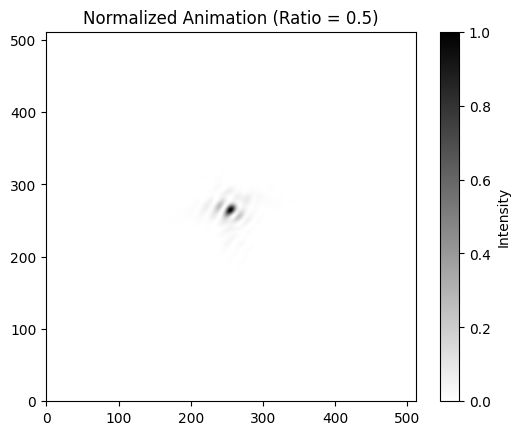

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter


normalized_data_cube_half = np.array([normalize_frame(frame) for frame in data_cube_half])

fig, ax = plt.subplots()

im = ax.imshow(normalized_data_cube_half[0], origin='lower', cmap="gray_r", vmin=0, vmax=1)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensity')

def update(frame):
    im.set_array(normalized_data_cube_half[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=normalized_data_cube_half.shape[0], interval=10, blit=True)

ffmpeg_writer = FFMpegWriter(fps=100, metadata={'artist': 'Me'}, bitrate=1800)
ani.save('Normalized Animation (Ratio = 0.5).mp4', writer=ffmpeg_writer)

plt.title("Normalized Animation (Ratio = 0.5)")
plt.show()


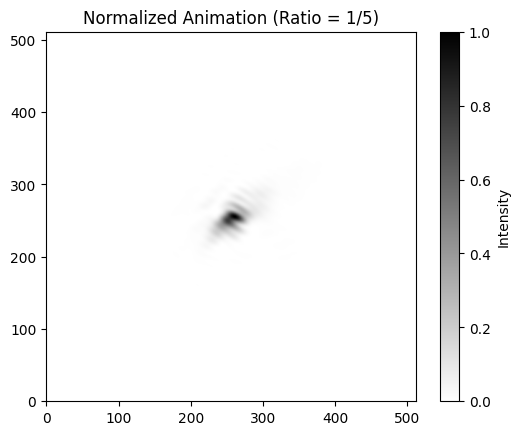

In [113]:
normalized_data_cube_fifth = np.array([normalize_frame(frame) for frame in data_cube_fifth])

fig, ax = plt.subplots()

im = ax.imshow(normalized_data_cube_fifth[0], origin='lower', cmap="gray_r", vmin=0, vmax=1)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensity')

def update(frame):
    im.set_array(normalized_data_cube_fifth[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=normalized_data_cube_fifth.shape[0], interval=10, blit=True)

ffmpeg_writer = FFMpegWriter(fps=100, metadata={'artist': 'Me'}, bitrate=1800)
ani.save('Normalized Animation (Ratio = 0.2).mp4', writer=ffmpeg_writer)

plt.title("Normalized Animation (Ratio = 1/5)")
plt.show()

# Not normalized:

Text(0.5, 1.0, 'Not Normalized Animation (Ratio = 1)')

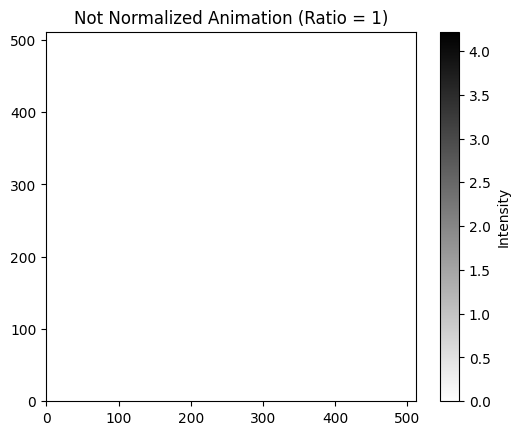

In [114]:
vmin = np.min(data_cube_1)
vmax = np.max(data_cube_1)
fig, ax = plt.subplots()

im = ax.imshow(data_cube_1[0], origin='lower', cmap="gray_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensity')

def update(frame):
    im.set_array(data_cube_1[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=data_cube_1.shape[0], interval=10, blit=True)

ffmpeg_writer = FFMpegWriter(fps=100, metadata={'artist': 'Me'}, bitrate=1800)
ani.save('Not Normalized Animation (Ratio = 1).mp4', writer=ffmpeg_writer)

plt.title("Not Normalized Animation (Ratio = 1)")


Text(0.5, 1.0, 'Not Normalized Animation (Ratio = 1/2)')

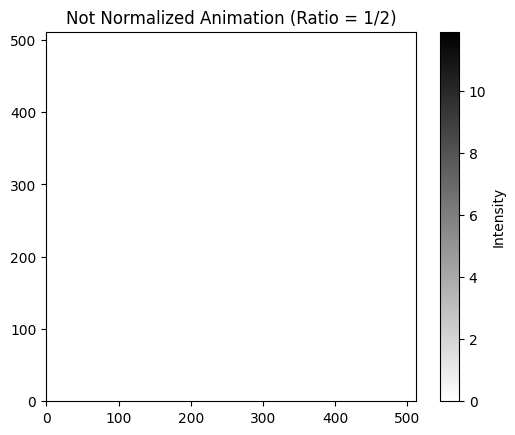

In [115]:
vmin = np.min(data_cube_half)
vmax = np.max(data_cube_half)

fig, ax = plt.subplots()

im = ax.imshow(data_cube_half[0], origin='lower', cmap="gray_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensity')

def update(frame):
    im.set_array(data_cube_half[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=data_cube_half.shape[0], interval=10, blit=True)

ffmpeg_writer = FFMpegWriter(fps=100, metadata={'artist': 'Me'}, bitrate=1800)
ani.save('Not Normalized Animation (Ratio = 0.5).mp4', writer=ffmpeg_writer)

plt.title("Not Normalized Animation (Ratio = 1/2)")

Text(0.5, 1.0, 'Not Normalized Animation (Ratio = 1/5)')

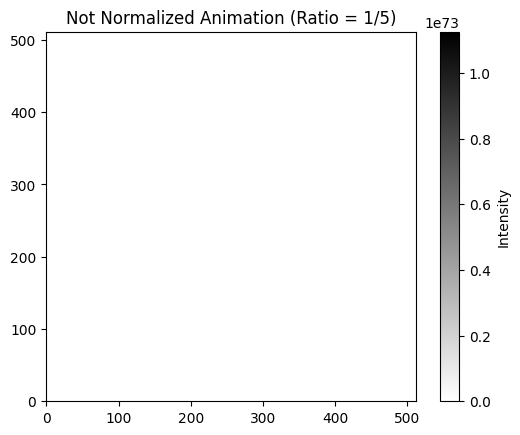

In [116]:
vmin = np.min(data_cube_fifth)
vmax = np.max(data_cube_fifth)

fig, ax = plt.subplots()

im = ax.imshow(data_cube_fifth[0], origin='lower', cmap="gray_r", vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensity')

def update(frame):
    im.set_array(data_cube_fifth[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=data_cube_fifth.shape[0], interval=10, blit=True)

ffmpeg_writer = FFMpegWriter(fps=100, metadata={'artist': 'Me'}, bitrate=1800)
ani.save('Not Normalized Animation (Ratio = 0.2).mp4', writer=ffmpeg_writer)

plt.title("Not Normalized Animation (Ratio = 1/5)")